In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
import pyshtools as psh
from scipy.interpolate import interp1d
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
from scipy import integrate
from scipy import special as sp
import scipy.integrate
from scipy.interpolate import CubicSpline
import seaborn as sns
import math
plt.rcParams['figure.figsize'] = (8, 6)
from IPython.display import Image
from IPython.core.display import HTML 
import timeit
from matplotlib import rc, rcParams
import pandas as pd
rc('text',usetex=True);rc('font',size ="16");rc('axes',labelsize ="26")
import imageio
from sympy.physics.quantum.cg import Wigner3j

In [2]:
vol=np.array([100.*(10**9.)])
z_array=np.zeros((1))
n_z=np.array([3.*(10**(-4))])
n_pts=50

In [96]:
z_array

array([0.])

In [3]:

fid_params={'h':[0.6781], 'Omb':[0.0484], 'Omc':[0.2596], 'ns':[0.9677], 'As':[2.139e-09], 'w':[-1.0]}
print ('Fiducial Parameters:', fid_params)   # The value of As cn=ontrols the final amplitude


#List of fiducial parameters:
params_f=[p[0] for p in fid_params.values()]

Fiducial Parameters: {'h': [0.6781], 'Omb': [0.0484], 'Omc': [0.2596], 'ns': [0.9677], 'As': [2.139e-09], 'w': [-1.0]}


In [4]:
def Power_spectrum(param, Z_bin, K_max):
    h, Omb, Omc, n_s, A_s, w = param
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100.*h, ombh2=Omb*(h**2), omch2=Omc*(h**2.), omk=0)
    pars.set_dark_energy(w)
    pars.InitPower.set_params(As= A_s, ns=n_s)
    pars.set_matter_power(redshifts=Z_bin, kmax=K_max)

    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=K_max, npoints = n_pts)
    ## k values in h/Mpc
    t = results.get_matter_transfer_data()
    s8 = np.array(results.get_sigma8())
    qt=t.transfer_data[0, :, 0]
    transf=[]
    for i in range(len(Z_bin)):
        transf_interp=interp1d(qt, t.transfer_data[6, :, i])
        transf.append(transf_interp(kh))
    print("z=",Z_bin,"Sigma_8=",s8 , "Om_cdm",Omc,"Om_b",Omb,"A_s",A_s,"h=",h)
    return kh, pk, np.array(transf)[::-1,:]

c_light_km_s =  299792

In [5]:
h, Omb, Omc, n_s, A_s, w = params_f
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.*h, ombh2=Omb*(h**2), omch2=Omc*(h**2.), omk=0)
pars.set_dark_energy(w)
results = camb.get_background(pars)

In [8]:
zs =1.0
mu1s =0.5
ks =0.05


w =-1
#H0=299792.
col1,col2,col3,col4,col5,col6,col7,col8,col9 = np.loadtxt('/Users/o-admin/Dropbox/Forecast/Workshop/tabula-1807.07076v2 porciani.txt',unpack=True)# z =0.5 ,



Euchb10 = interp1d(col1, col4)
Euchb20 = interp1d(col1, col5)
Euchbs2 = interp1d(col1, col6)

In [9]:
def chi(z):
    #comoving radial distance (Mpc) in CAMB
    CD = results.comoving_radial_distance(z)*h #Mpc/h
    return CD


def CH(z):   
    CD = results.h_of_z(z)/h  #h/Mpc
    return CD


def CHH(z):
    return CH(z)/(1.0 + z)  
    

def Omg_m(z):
    h, Omb, Omc, n_s, A_s, w = params_f
    A= 1./(1.+z)
    tmp =(((Omc+Omb)/((A**3.)*((CH(z)**2.)/(CH(0.0)**2.))))) ##I need to change this. CAll this directly from CAMB
    return tmp
  
def fg(z):
    f=(Omg_m(z))**0.55  ##Call this directly from CAMB
    return f

def fgpr(z):
     #tmp = 0.5*(3.0*Omg_m(z) -4.)*fg(z) - fg(z)*fg(z) + 1.5*fg(z)
    conformaltoredshift = -(1.0+ z)*CHH(z)
    ep = 1e-4
    tmp = (fg(z + ep) -fg(z -ep))/(2.0*ep)
    return tmp*conformaltoredshift

def CHpr(z):
    tmp = CHH(z)*CHH(z)*(1.0 - 1.5 *Omg_m(z))
   # ep = 1e-4
    #conformaltoredshift = -(1.0+ z)*CHH(z)
    #tmp = (CHH(z + ep)-CHH(z-ep))/(2.0*ep)
    #return conformaltoredshift*tmp
    return tmp
   

def CHpr2(z):
    ep = 1e-4
    conformaltoredshift = -(1.0+ z)*CHH(z)
    tmp = (CHpr(z + ep)-CHpr(z-ep))/(2.0*ep)
    return conformaltoredshift*tmp

def E(A, params):
    h, Omb, Omc, n_s, A_s, w = params
    omg_de = 1.0 - (Omc + Omb)
    return np.sqrt((Omc/(A**3.) + omg_de/(A**(3.*(1.+w)))))

def growth1(params,z):
    h, Omb, Omc, n_s, A_s, w = params 
    A= 1./(1.+z)
    a2=np.linspace(10**(-7), A, 200)
    e=np.array([E(i, params) for i in a2])
    return 2.5*(Omc+Omb)*E(A, params)*integrate.simps((a2*e)**(-3.), a2)

def DDg(z):
    return growth1(params_f,z)/growth1(params_f,0.0)

a1=np.linspace(0.0,4, 200)
D1=np.array([DDg(i) for i in a1])
fg1=np.array([fg(i) for i in a1])
Dg = interp1d(a1,D1)
   
    
D2=np.array([Dg(i) for i in a1])

In [94]:
Zarray2 = np.linspace(0.002,2.0, 50)

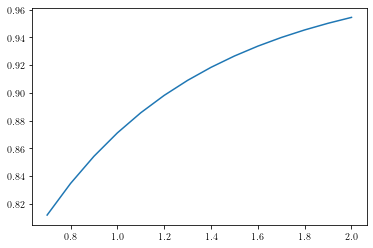

In [71]:
plt.plot(Zarray2,fg(Zarray2))

In [72]:
fg(1.0)

0.8710555127387887

In [84]:
DDg(1.0)

0.6217291829921697

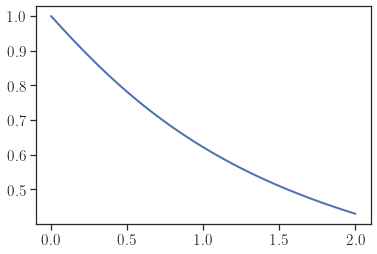

In [95]:
plt.plot(Zarray2,Dg(Zarray2))

In [11]:
#Obs systematics

def bevo(z):
    return beOx(z) #-4.0 #0.3 +z*0.2 #-4.0 #

def bevopr(z):
    conformaltoredshift = -(1.0+ z)*CHH(z)
    return bevo(z)*conformaltoredshift

def dB10dL(z):
    #return 0.0580776 + 0.0751623* z- 0.00891*z**2 + 0.000826* z**3
    return 0.0

def curlyQ(z):
    return -(-0.66 -2.95*z + 1.59* z**2 - 0.4* z**3 + 0.04* z**4) ##Sheean ##EUCLID
    ##return 1.0 ## SKA

def LumS(z):    
    return 2.0*curlyQ(z)/5.0 #-0.95


def B10(z):
    #return  0.750 + 0.087* z+ 0.019* z**2  ##SKA
    return 0.9 + 0.4 *z  ##EUCLID

def B10pr(z):
    ep = 1e-4
    tmp = (B10(z + ep) -B10(z- ep ))/(2.0*ep)
    conformaltoredshift = -(1.0+ z)*CHH(z)
    return tmp*conformaltoredshift  #-1.6e-4

def B20(z):
    #return (0.412 - 2.143*B10(z) + 0.929*(B10(z)**2.) + 0.008*(B10(z)**3.))/2.0
    #return -0.704172 -0.207993 *z +0.183023 *z**2-0.00771288 *z**3
    #return -0.257- 0.063 *z - 0.007 *z**2 + 0.006* z**3
    #return -0.30 + 0.087* z+ 0.019* z**2
    return Euchb20(z)

def Tidalbias(z):
    return -4.0*(B10(z) - 1.0)/7.

In [154]:

def AA(z):
    #IC.bevo(z) + 1.5 * IC.Omegam(z) - 3.0* (2.0 - 5.0*s)*(1.0- 1.0/(IC.chi(z)*IC.HH(z)))
    tmp = bevo(z)  + 1.5*Omg_m(z) - 3.0 + (2.0 - 5.0*LumS(z))*(1.0-1.0/(chi(z)*CHH(z) )) 
    return tmp

def CC(z):
    tmp = B10(z)*(AA(z) + fg(z)) + B10pr(z)/CHH(z) + 2.0*(1.0-1.0/(chi(z)*CHH(z) ))*dB10dL(z)
    return tmp

def EE(z):
    tmp = 4.0 - 2.0*AA(z) - 1.5*Omg_m(z)
    return tmp

def F_2(a,b,c):
    cos=-(a**2. + b**2. -(c**2.))/(2.*a*b)
    return 2.0*(5./7. + ((a*b*cos)/(2.*a*b))*((a/b) + (b/a)) + (2./7.)*(((a*b*cos)/(a*b)))**2.)

def G_2(a,b,c):
    cos=-(a**2. + b**2. -(c**2.))/(2.*a*b)
    return 2.0*(3./7. + ((cos)/(2.))*((a/b) + (b/a)) + (4./7.)*(((cos))**2.))


def S_2(a,b,c):
    cos=-(a**2. + b**2. -(c**2.))/(2.*a*b)
    return ((a*b*cos)**2.)/(a*b*a*b) - 1./3.


def KN_1(z, mu1):                            
    return (B10(z) +  fg(z)*mu1**2) #Multiply by D because it is not in the power spectrum

def KN_2(x,z, a, b, c, mu1,mu2,mu3):                    
    Line1 = B10(z)*F_2(a,b,c)  +  B20(z) + fg(z)*mu3*mu3*G_2(a,b,c) + Tidalbias(z)*S_2(a,b,c)
    #Z2 = (fg(z)*mu3*c)* ((mu1/a)*(B10(z) +  fg(z)*mu2**2) + (mu2/b)*(B10(z) +  fg(z)*mu1**2))
    Line2 = fg(z)*fg(z)*(2.0* (mu1**2)*(mu2**2) + mu1*mu2*((mu1**2)*a/b + (mu2**2)*b/a))
    Line3 = fg(z)*B10(z)*(mu1**2 + mu2**2  + mu1*mu2*(a/b + b/a)) 
    if x == 1:
            return B10(z)*F_2(a,b,c) #+ B20(z) + fg(z)*mu3*mu3*G_2(a,b,c)
    if x == 2:
            return B20(z)
    if x == 3:
            return fg(z)*mu3*mu3*G_2(a,b,c)
    if x == 4:
            return Tidalbias(z)*S_2(a,b,c)
    if x == 5:
            return (Line2 + Line3)
    if x == 6:
            return Line1
    if x == 7:
            return (Line1+ Line2 + Line3)
     
    
def KD_1(z,a, mu1):                            
    return AA(z)*fg(z)*mu1*CHH(z)/a

def KD_2(x,z, a, b, c, mu1,mu2,mu3): 
    cos=-(a**2. + b**2. -(c**2.))/(2.0*a*b)
    Term1 = -1.5*(mu1*(a/(b**2)) + mu2*(b/(a**2)))*Omg_m(z)*B10(z) 
    Term2 =  2.0*cos *(mu1/b + mu2/a)*fg(z)**2
    Term3 = (mu1/a + mu2/b)*fg(z) *CC(z)
    Term4 = -1.5*((mu1**3)*(a/(b**2)) + (mu2**3) *(b/(a**2)))*Omg_m(z)*fg(z) 
    Term5 =  mu1*mu2*(mu1/b + mu2/a)*(1.5*Omg_m(z) - EE(z)*fg(z))*fg(z)
    Term6 = mu3*G_2(a,b,c)*AA(z)*fg(z)/c
    if x == 1:
            return CHH(z)*Term1
    if x == 2:
            return CHH(z)*Term2
    if x == 3:
            return CHH(z)*Term3
    if x == 4:
            return CHH(z)*Term4
    if x == 5:
            return CHH(z)*Term5
    if x == 6:
            return CHH(z)*Term6
    if x == 7:
            return CHH(z)*(Term1 + Term2 + Term3 + Term4 + Term5 + Term6)
    
    
    
    

In [155]:
def NewtonainBispecKernel(x,z, a, b, c, mu1,mu2,mu3):
    tmp1 = KN_1(z, mu1)*KN_1(z, mu2)*KN_2(x,z, a, b, c, mu1,mu2,mu3)
    return tmp1

def DipoleBispecKernel(x, z, a, b, c, mu1,mu2,mu3):
    tmp1 = KN_1(z, mu1)*KN_1(z, mu2)*KD_2(x,z, a, b, c, mu1,mu2,mu3)
    tmp2 = (KN_1(z, mu1)*KD_1(z,b, mu2) + KD_1(z,a, mu1)*KN_1(z, mu2))*KN_2(7,z, a, b, c, mu1,mu2,mu3)
    return   tmp1 + tmp2

In [156]:

k, P, T_tmp=Power_spectrum(params_f, z_array, 3)
P_interp=interp1d(k, P[0])
Transf=T_tmp[0,:]/T_tmp[0,0]
T_interp=interp1d(k, Transf)

z= [0.] Sigma_8= [0.81864687] Om_cdm 0.2596 Om_b 0.0484 A_s 2.139e-09 h= 0.6781


In [157]:
def clean_mu(cos_angle):
    #return min(1,max(cos_angle,-1))
    return cos_angle

def NewtonianBispectrum(x,z, K1, K2,Theta_12, Omega, Phi):
    K3 = np.sqrt(K1**2 + K2**2 + 2.0* K1*K2* np.cos(Theta_12))
    #Mu_12 = clean_mu(-(K1**2. + K2**2. -(K3**2.))/(2.*K1*K2))
    Mu_12 = np.cos(Theta_12)
    Mu_1= np.cos(Omega)
    Mu_2=  Mu_12*np.cos(Omega) + math.sqrt((1.0-Mu_12**2))*np.sin(Omega)*np.cos(Phi) 
    Mu_3= (-K1/K3)*Mu_1 + (-K2/K3)*Mu_2
    BgN = (NewtonainBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                 + NewtonainBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                 + NewtonainBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    
    return (Dg(z)**4)*BgN

def DipoleBispectrum(x,z, K1, K2, Theta_12, Omega, Phi):
    K3 = np.sqrt(K1**2 + K2**2 + 2.0* K1*K2* math.cos(Theta_12))
    Mu_12 = math.cos(Theta_12)
    #Mu_12 = clean_mu((-K1**2 - K2**2. +(K3**2.))/(2.*K1*K2))
    Mu_1= math.cos(Omega)
    Mu_2 = Mu_1* Mu_12 + math.sqrt(1.0 - clean_mu(Mu_1)**2 )*math.sqrt(1.0- (Mu_12)**2)*math.cos(Phi);
    #Mu_2= Mu_12*np.cos(Omega) +  math.sqrt(abs(1.0-Mu_12**2))*np.sin(Omega)*np.sin(Phi) 
    Mu_3= (-K1/K3)*Mu_1 + (-K2/K3)*Mu_2
    BgD = (DipoleBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                + DipoleBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                +DipoleBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    
    return  (Dg(z)**4)*BgD
    

In [158]:
def NewtonainPowerpectrum(z, mu1,K1):
    return ((Dg(z)*KN_1(z, mu1))**2)*P_interp(K1)

In [159]:
NewtonainPowerpectrum(1.0, 1.0,0.05/h)/h**3

54866.79472236117

In [20]:
n_z2 = col3*10**(-3)
vol2 = col2*10**9
Z_bins3 = col1
sigmP = col9

In [160]:

def DFOGP(k,mu, sig):
    return np.exp(-((k*sig* mu)**2)/2.0)

def BFOGB(k1,k2,k3,mu1,mu2,mu3,sig):
    sigB = sig
    return np.exp(-(( (k1* mu1)**2 +(k2* mu2)**2 + (k3* mu3)**2)*sigB**2)/2.0)

def NewtonianBispectrumTot(z, K1, K2,K3,Mu_1,Mu_2,Mu_3):
    x =7
    #Mu_12 = (-K1**2 - K2**2. +(K3**2.))/(2.*K1*K2)
    #Mu_1= np.cos(Omega)
    #Mu_2=  Mu_12*Mu_12 + math.sqrt((1.0-Mu_12**2))*np.sin(Omega)*np.cos(Phi) 
    #Mu_3= (-K1/K3)*Mu_1 + (-K2/K3)*Mu_2
    BgN = (NewtonainBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                 + NewtonainBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                 + NewtonainBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    
    return (Dg(z)**4)*BgN



def DipoleBispectrumTot(z, K1, K2,K3,Mu_1,Mu_2,Mu_3):
    x =7
    BgD = (DipoleBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                + DipoleBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                +DipoleBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    
    return  (Dg(z)**4)*BgD



def NewtonianBispectrumTot2(z, K1, K2,K3,Mu_1,Mu_2,Mu_3,sig):
    x =7
    #Mu_12 = (-K1**2 - K2**2. +(K3**2.))/(2.*K1*K2)
    #Mu_1= np.cos(Omega)
    #Mu_2=  Mu_12*Mu_12 + math.sqrt((1.0-Mu_12**2))*np.sin(Omega)*np.cos(Phi) 
    #Mu_3= (-K1/K3)*Mu_1 + (-K2/K3)*Mu_2
    BgN = (NewtonainBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                 + NewtonainBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                 + NewtonainBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    
    return (Dg(z)**4)*BgN*BFOGB(K1, K2,K3,Mu_1,Mu_2,Mu_3,sig)



def DipoleBispectrumTot2(z, K1, K2,K3,Mu_1,Mu_2,Mu_3,sig):
    x =7
    BgD = (DipoleBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                + DipoleBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                +DipoleBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    
    return  (Dg(z)**4)*BgD*BFOGB(K1, K2,K3,Mu_1,Mu_2,Mu_3,sig)






def PS_galtot(z,K1,Mu):
    return NewtonainPowerpectrum(z,Mu,K1)

def PS_gal2array2(Rarray,K1, mu1_array):
    PS = np.zeros((len(Rarray),len(mu1_array)))
    for i in range(len(Rarray)):
        for j in range(len(mu1_array)):
            
            PS[:,:] = PS_galtot(Rarray[i],K1,mu1_array[j])
    return PS 


def PS_gal2array1(Rarray,K1, mu1):
    for i in range(len(Rarray)):
        PS = np.zeros((len(Rarray)))
        PS[:] = PS_galtot(Rarray[i],K1,mu1)
    return PS 




In [163]:
def NewtonianBispectrumTot_test(z, K1, K2,K3,Mu_1,Phi):
    x =7
    #Phi = 0.0
    Mu_12 = (-K1**2 - K2**2. +(K3**2.))/(2.*K1*K2)
    Omega= math.acos(Mu_1)
    #mu2= np.cos(T_12)*mu1+ np.sin(T_12)*np.outer(np.sqrt(1.-(mu**2.)),np.cos(Phi)) 
    
    Mu_2=  Mu_1*Mu_12 + math.sqrt((1.0-Mu_12**2))*np.sin(Omega)*np.cos(Phi) 
    
    Mu_3= (-K1/K3)*Mu_1 + (-K2/K3)*Mu_2
    BgN = (NewtonainBispecKernel(x,z, K1, K2, K3,Mu_1,Mu_2, Mu_3)*(P_interp(K1)*P_interp(K2))
                 + NewtonainBispecKernel(x,z,K2, K3, K1,Mu_2, Mu_3,Mu_1)*P_interp(K2)*P_interp(K3)
                 + NewtonainBispecKernel(x,z, K3, K1, K2,Mu_3,Mu_1,Mu_2)*(P_interp(K3)*P_interp(K1)))
    #Mu_2, Mu_3,
    return  (Dg(z)**4)*BgN


In [164]:
NewtonianBispectrumTot_test(1.0, 0.05/h,0.05/h,0.05/h,1.0,0.0)/h**6

668045235.415765

In [42]:
muarrsay=  np.cos(np.linspace(0.0, np.pi, 50))

In [53]:
def computekmax(Nkbins,kmin,kmax):
    KK =np.zeros(Nkbins)
    for i in range(Nkbins):
        KK[i] = np.exp(np.log(kmin) + (np.log(kmax)-np.log(kmin))*i/(Nkbins-1))
    return KK

In [97]:
NewtonainPowerpectrum(Z_bins3,0.2,0.02)*h**3

array([5532.50253456, 5394.80157321, 5260.9570395 , 5132.14193972,
       5009.04971864, 4892.02681419, 4781.17506828, 4676.42881676,
       4577.61172024, 4484.47791667, 4396.7413282 , 4314.09617751,
       4236.2310725 , 4162.83844121])

In [105]:
def SignalToNoiseP(K, redshift, Nz_spec, Vol):
    Omega=np.linspace(0.0, np.pi, 100)
    mu=np.cos(Omega)
    N_spec=(Nz_spec.reshape((len(redshift),1)))*np.ones((len(redshift),len(Omega)))
    Volume=(Vol.reshape((len(Vol),1)))*np.ones((len(Vol),len(Omega)))
    #integrand_k = []
    P_gg1 = np.zeros((len(K)))
    P_gg2 = np.zeros((len(redshift), len(Omega)))
    integrand_K =[]
    P_gg = np.zeros((len(redshift),len(Omega),len(K)))
    for i in range(len(K)):
      
        P_gg2[:,:] = PS_gal2array2(redshift, K[i],np.cos(Omega))

        integrand_mu = sum((K[i]**2.)*(P_gg2[:,:]*P_gg2[:,:])*Volume/((2.0*(2.*np.pi)**2)*(((PS_gal2array2(redshift,K[i],np.cos(Omega))+ (1./N_spec))**2.))))
        
            
        integrand_K.append(integrate.simps(-integrand_mu, mu))
       
    
    F_spec = integrate.simps(integrand_K, K)
    
    return F_spec


                                  

In [106]:
SNP = SignalToNoiseP(computekmax(20,1e-4,0.15),Z_bins3[3:4],n_z2[3:4],vol2[3:4])

In [107]:
np.sqrt(SNP)

313.23639267495116

In [58]:
n_z2[0:1]
    

array([0.00276])

In [176]:
Zarray = np.linspace(0.7,2.0,10)

In [184]:
Zarray 

array([0.7       , 0.84444444, 0.98888889, 1.13333333, 1.27777778,
       1.42222222, 1.56666667, 1.71111111, 1.85555556, 2.        ])

In [186]:
Zarray[Zarray <= 1.0]

array([0.7       , 0.84444444, 0.98888889])

In [187]:
Z_bins3[0]

0.7

In [189]:
np.arange(max(Z_bins3[0],abs(Z_bins3[3]-Z_bins3[2])),Z_bins3[3]+0.1,0.1)

array([0.7, 0.8, 0.9, 1. , 1.1])

In [69]:
Z_bins3

array([0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
       2. ])

In [77]:
computekmax(20,1e-4,0.15)

array([1.00000000e-04, 1.46947668e-04, 2.15936171e-04, 3.17313167e-04,
       4.66284298e-04, 6.85193902e-04, 1.00687646e-03, 1.47958147e-03,
       2.17421047e-03, 3.19495158e-03, 4.69490683e-03, 6.89905610e-03,
       1.01380020e-02, 1.48975576e-02, 2.18916134e-02, 3.21692153e-02,
       4.72719117e-02, 6.94649717e-02, 1.02077156e-01, 1.50000000e-01])

In [108]:
def SNratioJustP(zarray,kmin,n_zarray,volarray, NKbins):
    Zbins =np.zeros((len(zarray)))
    sigmagnl =np.zeros((len(zarray)))
    sigmagnlT =np.zeros((len(zarray)))
    sigmagnlP =np.zeros((len(zarray)))
    for i in range(len(zarray)): 
        Zbins[i] = zarray[i]
        sigmagnl[i] = np.sqrt(SignalToNoiseP(computekmax(20,1e-4,0.15), zarray[i:1+i], n_zarray[i:1+i],  volarray[i:1+i]))
        #sigmagnlT[i] = np.sqrt(SignalToNoiseP(Computeks(NKbins,kmin,zarray[i:1+i]), zarray[i:1+i], n_zarray[i:1+i], volarray[i:1+i]))
        #sigmagnlP[i] = np.sqrt(SignalToNoiseMultipoles(Computeks(NKbins,10**-4,zarray[i:1+i]), zarray[0:1+i], n_zarray[0:1+i], volarray[0:1+i],1,1))
        #,sigmagnlT,sigmagnlP
    return Zbins, sigmagnl #,sigmagnlT


In [109]:
ZA,SNRP  = SNratioJustP(Z_bins3,4.2e-4,n_z2,vol2, 100)


Text(0, 0.5, '${\\rm{cummulative}~S/N}$')

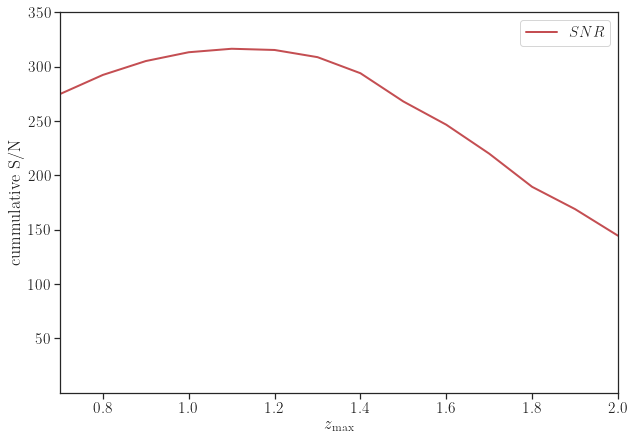

In [110]:
sns.set(style='ticks',font_scale=1.4,rc={"lines.linewidth": 2.})
plt.figure(figsize=(10,7))
#plt.subplot(1,2,1)


plt.plot(ZA,SNRP, 'r-',label=r'$SNR$')


plt.ylim(1e-2,350)
plt.xlim(0.7,2)

plt.legend(loc='best')
#plt.title(r'$\mu =1, \phi = \pi$')
plt.xlabel(r'$z_{\rm{max}}$')
plt.ylabel(r'${\rm{cummulative}~S/N}$')

In [36]:
def Computeks(Nkbins,kmin,z):
    KK =np.zeros(Nkbins)
    Knl = 0.15*h #0.2*h*(1.0+z)**(2.0/(2.0+ n_s))
    for i in range(Nkbins):
        KK[i] = np.exp(np.log(kmin) + (np.log(Knl)-np.log(kmin))*i/(Nkbins-1))
        #KK[i] =  kmin +  i*(Knl-kmin)/Nkbins
    return KK
    #return np.logspace(np.log10(kmin), np.log10(Knl), Nkbins)

In [ ]:
def angle(a,b,c):
    return math.acos(-(a**2. + b**2. -(c**2.))/(2.*a*b))



def SignalToNoiseBN(K, redshift, Nz_spec, Vol):
    Omega=np.linspace(0.0,np.pi, 50)
    Phi=np.linspace(0., 2.*np.pi, 51)
    #k1 integral
    integrand1=[]
    for i in range(len(K)):
        integrand2=[]
        k2=[]
        for j in range(i,len(K)):
            k2.append(K[j])
            integrand3=[]
            k3=[]
            for l in range(j,len(K)):
                k_lim=min((K[i]+K[j]), max(K))
                if K[l]<=k_lim:
                    k3.append(K[l])
                    for y in range(len(redshift)):
                    
                    
                        T_12=angle(K[i], K[j], K[l]) #DFOGP(k,mu, sig)
                    
                        mu=np.cos(Omega)
                        mu1=np.outer(mu, np.ones((len(Phi))))
                        mu2=np.sin(T_12)*np.outer(np.sqrt(1.-(mu**2.)),np.cos(Phi)) + np.cos(T_12)*mu1
                        #print(np.outer(np.sqrt(1.-(mu**2.)),np.cos(Phi)))
                        mu3=(-K[i]/K[l])*mu1 + (-K[j]/K[l])*mu2
                        Delz = 1.0
                
                        #B_tot=np.zeros((2,len(redshift), len(Omega), len(Phi)))
                        B_tot=np.zeros((len(redshift), len(Omega), len(Phi)))
                        #B_totalNzarray1(redshift,K[i],K[j], K[l], mu1, mu2, mu3)
                        if (K[i] == K[j]==K[l]):
                            SB = 6.0
                            B_tot[:,:,:]=NewtonianBispectrumTot(redshift[y],K[i],K[j], K[l], mu1, mu2, mu3)                        
                            integrandz = (B_tot[:,:,:]*((K[i]*K[j]*K[l]*Vol[y]*Delz)/((SB*(2.0*np.pi)**5.)
                                    *(PS_galtot(redshift[y],K[i], mu1) +(1./Nz_spec[y]))
                                    *(PS_galtot(redshift[y],K[j],mu2)+(1./Nz_spec[y]))
                                    *(PS_galtot(redshift[y],K[l],mu3)+(1./Nz_spec[y]))))*B_tot[:,:,:])
                        elif (K[i] == K[j]>K[l]):
                            SB = 2.0
                            B_tot[:,:,:]=NewtonianBispectrumTot(redshift[y],K[i],K[j], K[l], mu1, mu2, mu3)                        
                            integrandz = (B_tot[:,:,:]*((K[i]*K[j]*K[l]*Vol[y]*Delz)/((SB*(2.0*np.pi)**5.)
                                    *(PS_galtot(redshift[y],K[i], mu1) +(1./Nz_spec[y]))
                                    *(PS_galtot(redshift[y],K[j],mu2)+(1./Nz_spec[y]))
                                    *(PS_galtot(redshift[y],K[l],mu3)+(1./Nz_spec[y]))))*B_tot[:,:,:])
                        else: 
                            SB = 1.0
                            B_tot[:,:,:]=NewtonianBispectrumTot(redshift[y],K[i],K[j], K[l], mu1, mu2, mu3)                        
                            integrandz = (B_tot[:,:,:]*((K[i]*K[j]*K[l]*Vol[y]*Delz)/((SB*(2.0*np.pi)**5.)
                                    *(PS_galtot(redshift[y],K[i], mu1) +(1./Nz_spec[y]))
                                    *(PS_galtot(redshift[y],K[j],mu2)+(1./Nz_spec[y]))
                                    *(PS_galtot(redshift[y],K[l],mu3)+(1./Nz_spec[y]))))*B_tot[:,:,:])
                        #print(B_tot)
                        #print(B_tot)
                     
                        integrand5 = integrate.simps(integrandz, Phi)
                        integrand4 = integrate.simps(-integrand5, mu)
                     
                    integrand3.append(sum(integrand4)) 
                   # integrand3.append(integrate.simps(integrand4, redshift)) 
            integrand2.append(integrate.simps(np.array(integrand3).reshape((len(k3))), k3))
        integrand1.append(integrate.simps(integrand2, k2))
    F=integrate.simps(integrand1, K)
    return F

In [ ]:
range(4)

In [ ]:
SNratioN = SignalToNoiseBN(computekmax(20,1e-4,0.15), Z_bins3[3:4], n_z2[3:4], vol2[3:4])

In [125]:
np.sqrt(SNratioN)

80.67849331864244

In [123]:
Z_bins3[3:4]

array([1.])

In [ ]:
ZA2, SNRPkeq2,SNRPkeq  = SNratioJustP(Z_bins3,5e-2,n_z2,vol2, 100)
#ZAmax2, SNRPkeqmax2  = SNratioJustPMax(Z_bins3,5e-2,n_z2,vol2, 100)

In [172]:
def SNratioJustPB(zarray,karray,n_zarray,volarray, NKbins):
    Zbins =np.zeros((len(zarray)))
    sigmagnl =np.zeros((len(zarray)))
    sigmagnlT =np.zeros((len(zarray)))
    #sigmagnlMax =np.zeros((len(zarray)))
    #sigmagnlTMax =np.zeros((len(zarray)))
    
    sigmagnlP =np.zeros((len(zarray)))
    for i in range(len(zarray)): 
        Zbins[i] = zarray[i]
        sigmagnl[i] = np.sqrt(SignalToNoiseBN(karray, zarray[i:1+i], n_zarray[i:1+i],  volarray[i:1+i]))
        sigmagnlT[i] = np.sqrt(SignalToNoiseP(karray, zarray[i:1+i], n_zarray[i:1+i],  volarray[i:1+i]))
        #sigmagnlT[i] = np.sqrt(SignalToNoiseBGR5(karray, zarray[i:1+i], n_zarray[i:1+i], volarray[i:1+i],sig[i:1+i]))
     
    return Zbins, sigmagnl,sigmagnlT 


In [173]:
ZA,SNRP,SNRB  = SNratioJustPB(Z_bins3,computekmax(100,1e-4,0.15),n_z2,vol2, 100)


Text(0, 0.5, 'SNR')

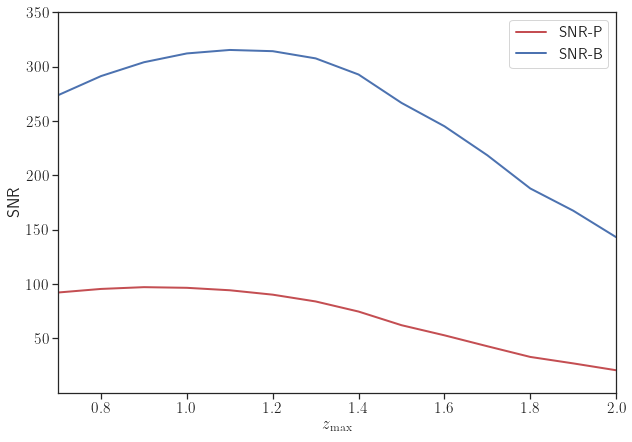

In [190]:
sns.set(style='ticks',font_scale=1.4,rc={"lines.linewidth": 2.})
plt.figure(figsize=(10,7))
#plt.subplot(1,2,1)


plt.plot(ZA,SNRP, 'r-',label=r'SNR-P')
plt.plot(ZA,SNRB, 'b-',label=r'SNR-B')


plt.ylim(1e-2,350)
plt.xlim(0.7,2)

plt.legend(loc='best')
#plt.title(r'$\mu =1, \phi = \pi$')
plt.xlabel(r'$z_{\rm{max}}$')
plt.ylabel(r'SNR')

In [192]:
np.arange(0.01, 2, 0.4)

array([0.01, 0.41, 0.81, 1.21, 1.61])

In [193]:
min(0.002, abs(0.001-0.0012))

0.00019999999999999987